# Midterm Assignment 1 - Hinge Reviews on The Google Playstore

Importing libraries

In [1]:
import pandas as pd
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
import nltk


import collections
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS

import re
import string

import bitermplus as btm
import tmplot as tmp

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text


from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

Data Preprocessing

In [2]:
df = pd.read_csv('hinge_google_review.csv')

In [3]:
df.head()

reviewId                userName  \
0  005b4acd-94c5-49de-a314-a993090d0a53              Alex Pascu   
1  8365fefd-833d-4763-a250-129b35ee41d5          Nicole Roberge   
2  6e178db6-b4d6-4579-a04c-e67bdde6a907             David Crowe   
3  cbe0b303-ac77-40f0-9a77-245e8c0b5266           Matt Deflavis   
4  4c1e84b8-e25b-44b2-b44a-87cd177737e9  Ian Duda (VortexianZX)   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ACNPE...   
1  https://play-lh.googleusercontent.com/a/ALm5wu...   
2  https://play-lh.googleusercontent.com/a-/ACNPE...   
3  https://play-lh.googleusercontent.com/a-/ACNPE...   
4  https://play-lh.googleusercontent.com/a-/ACNPE...   

                                             content  score  thumbsUpCount  \
0  An algorithm that insists to match you with pe...      1              0   
1  Your app does not work whatsoever.. first of a...      1              0   
2  I would give this app no stars if I could. I s...      1              0   
3  Jumped back on recently, used to use it awhile...      3              0   
4  Talking to a girl and got randomly blocked. To...      5              0   

  reviewCreatedVersion                at replyContent repliedAt  
0                9.9.1   2022-11-05 2:48          NaN       NaN  
1                9.9.1   2022-11-05 1:56          NaN       NaN  
2                  NaN   2022-11-05 1:43          NaN       NaN  
3                9.9.1   2022-11-05 1:03          NaN       NaN  
4                9.9.1  2022-11-04 22:15          NaN       NaN

In [4]:
df.describe()

score  thumbsUpCount
count  58109.000000   58109.000000
mean       3.067993       2.201638
std        1.696079      15.777090
min        1.000000       0.000000
25%        1.000000       0.000000
50%        3.000000       0.000000
75%        5.000000       1.000000
max        5.000000    1169.000000

In [5]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt'],
      dtype='object')

In [6]:
df.isna().sum()

reviewId                    0
userName                    1
userImage                   0
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion     8174
at                          0
replyContent            57025
repliedAt               57025
dtype: int64

In [7]:
hinge = df.drop(['userImage','reviewCreatedVersion','replyContent','repliedAt'],axis=1)

In [8]:
hinge = hinge.dropna(subset=['content'])

Removing Punctuation, numbers, and lower case

In [9]:
# Load the regular expression library
import re

# Remove punctuation
hinge['review_processed'] = \
hinge['content'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
hinge['review_processed'] = \
hinge['review_processed'].map(lambda x: x.lower())

# Print out the first rows of reviews
hinge['review_processed'].head()

0    an algorithm that insists to match you with pe...
1    your app does not work whatsoever first of all...
2    i would give this app no stars if i could i sp...
3    jumped back on recently used to use it awhile ...
4    talking to a girl and got randomly blocked too...
Name: review_processed, dtype: object

In [10]:
hinge['review_processed'][4503]

"tried to sign up multiple times used my phone number never received the code tried signing up with facebook and it didn't work i was automatically taking to the phone number option only this sucks"

Creating a word cloud to visualize the most common terms

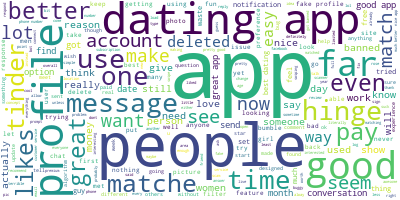

In [11]:
# Join the different processed reviews together.
long_string = ','.join(list(hinge['review_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

With the word cloud we are able to see the most common words. Words like app, profile and hinge will be added to the stopword list

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['app','hinge','profile','apps'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = hinge.review_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:][100][:30])

['whatever', 'ppl', 'saying', 'good', 'theyve', 'definitely', 'turned', 'iy', 'trash', 'algorithm', 'understands', 'preferences', 'dating', 'frontload', 'opposite', 'normal', 'match', 'potentials', 'itll', 'put', 'likely', 'say', 'yes', 'suggestions', 'behind', 'paywall', 'itll', 'suggest', 'pay', 'boosting']


In [13]:
hinge['content_removed'] = remove_stopwords(data_words)

In [14]:
hinge['content_removed'][:3]

0    [algorithm, insists, match, people, like, indi...
1    [work, whatsoever, first, let, upload, pics, p...
2    [would, give, stars, could, spent, lot, money,...
Name: content_removed, dtype: object

# Topic models
Now that the data has been cleaned, it is time to run the four topic model methods; LDA, NMF, CorEX, and BMT

# CorEX Models

In [15]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

import corextopic.corextopic as ct
import corextopic.vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline


In [16]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''    
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('�', ' ', text)    
    
    return text

In [17]:
round1 = lambda x: clean_text_round1(x)

# Clean Speech Text
hinge["content"] = hinge["content"].apply(round1)

# Visually Inspect
hinge.head()

reviewId                userName  \
0  005b4acd-94c5-49de-a314-a993090d0a53              Alex Pascu   
1  8365fefd-833d-4763-a250-129b35ee41d5          Nicole Roberge   
2  6e178db6-b4d6-4579-a04c-e67bdde6a907             David Crowe   
3  cbe0b303-ac77-40f0-9a77-245e8c0b5266           Matt Deflavis   
4  4c1e84b8-e25b-44b2-b44a-87cd177737e9  Ian Duda (VortexianZX)   

                                             content  score  thumbsUpCount  \
0  an algorithm that insists to match you with pe...      1              0   
1  your app does not work whatsoever   first of a...      1              0   
2  i would give this app no stars if i could  i s...      1              0   
3  jumped back on recently  used to use it awhile...      3              0   
4  talking to a girl and got randomly blocked  to...      5              0   

                 at                                   review_processed  \
0   2022-11-05 2:48  an algorithm that insists to match you with pe...   
1   2022-11-05 1:56  your app does not work whatsoever first of all...   
2   2022-11-05 1:43  i would give this app no stars if i could i sp...   
3   2022-11-05 1:03  jumped back on recently used to use it awhile ...   
4  2022-11-04 22:15  talking to a girl and got randomly blocked too...   

                                     content_removed  
0  [algorithm, insists, match, people, like, indi...  
1  [work, whatsoever, first, let, upload, pics, p...  
2  [would, give, stars, could, spent, lot, money,...  
3  [jumped, back, recently, used, use, awhile, ba...  
4  [talking, girl, got, randomly, blocked, took, ...

In [18]:
# Noun extract and lemmatize function

def nouns(text):
    #Given a string of text, tokenize the text 
    #and pull out only the nouns.   
    
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'    
    
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)    
    
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()    
    
    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    
    #return string of joined list of nouns
    return ' '.join(all_nouns)

# Create dataframe of only nouns from speeches
data_nouns = pd.DataFrame(hinge.content.apply(nouns))
hinge['content_processed'] = pd.DataFrame(hinge.content.apply(nouns))

# Visually Inspect
data_nouns.head()

content
0    algorithm people t indifferent sense waste time
1  app pic phone option fb picture people pic not...
2  i app star i lot money rose response like anyt...
3               limit like day message issue app app
4            girl l kinda ngl app quality connection

In [19]:
# Transform 20 newsgroup data into a sparse matrix
vectorizer = CountVectorizer(stop_words='english', binary=True)
doc_word = vectorizer.fit_transform(hinge.content)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(58107, 18027)

In [20]:
words = list(np.asarray(vectorizer.get_feature_names()))

In [21]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(58107, 18027)

In [22]:
# Train the CorEx topic model with 50 topics
topic_model = ct.Corex(n_hidden=10, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [23]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=1, n_words=10)

[('messages', 0.07381999736083077, 1.0),
 ('message', 0.04235852621311974, 1.0),
 ('send', 0.03519922986689642, 1.0),
 ('notifications', 0.02820145396384441, 1.0),
 ('profile', 0.028025873492405116, 1.0),
 ('doesn', 0.025234626254303096, 1.0),
 ('sent', 0.02169805749557912, 1.0),
 ('times', 0.02038608880344782, 1.0),
 ('fix', 0.02019193132467175, 1.0),
 ('update', 0.019290406807487788, 1.0)]

In [24]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: banned, account, reason, phone, support, customer, service, number, got, facebook
1: messages, message, send, notifications, profile, doesn, sent, times, fix, update
2: people, women, preferences, want, profiles, away, set, filter, match, miles
3: hinge, users, review, star, company, stop, single, report, asking, girl
4: better, tinder, apps, bumble, conversation, way, questions, really, user, actually
5: likes, like, pay, day, just, free, premium, limited, person, unless
6: dating, app, ve, best, used, met, worst, seen, online, probably
7: deleted, designed, fake, accounts, paid, months, subscription, scam, using, meant
8: time, waste, money, don, try, trying, spend, bother, photos, download
9: matches, getting, new, completely, point, suggested, list, cash, means, making


In [25]:

print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words

[5 8 5 ... 2 2 2]
(18027,)


In [26]:

# Print a single topic from CorEx topic model
topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(50061, 0.0),
 (28693, 0.0),
 (56257, 0.0),
 (31669, 0.0),
 (968, 0.0),
 (7635, 0.0),
 (4000, 0.0),
 (7593, 0.0),
 (42525, 0.0),
 (34064, 0.0)]

In [27]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(58107, 10)


In [28]:
print(np.mean(topic_model.log_z, axis=0))
print(topic_model.tcs)

[0.60837627 0.45254306 0.44733886 0.34850102 0.33573685 0.33102866
 0.20247972 0.19700491 0.16524533 0.10951467]
[0.60837627 0.45254306 0.44733886 0.34850102 0.33573685 0.33102866
 0.20247972 0.19700491 0.16524533 0.10951467]


In [29]:
print(topic_model.p_y_given_x[12])

[0.00228015 0.0061874  0.00310436 0.18954654 0.30273859 0.99919198
 0.99979631 0.99999386 0.02361092 0.02766112]


In [30]:
type(topic_model.p_y_given_x)

numpy.ndarray

In [31]:
topic_model.tc

3.1977693528595807

In [32]:
topic_model.tcs.shape # k_topics

(10,)

In [33]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

3.1977693528595807
3.1977693528595807


In [34]:

plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.savefig('corEX_correlation')

The first topic contains words pertaining to technical issues with the app such as account, service, support, and customer which is to be expected

In [35]:
topic_model.get_topics(topic=0, n_words=10, print_words=True)

[('banned', 0.08251171093108588, 1.0),
 ('account', 0.08000392563564361, 1.0),
 ('reason', 0.045286054725245384, 1.0),
 ('phone', 0.0374966281912533, 1.0),
 ('support', 0.03322336511588598, 1.0),
 ('customer', 0.03205017447468497, 1.0),
 ('service', 0.031398428217491475, 1.0),
 ('number', 0.029855012246904893, 1.0),
 ('got', 0.029231630862164328, 1.0),
 ('facebook', 0.024896380296617424, 1.0)]

In [36]:
topic_model.log_z.shape # n_docs x k_topics

(58107, 10)

In [37]:
print(np.mean(topic_model.log_z, axis=0))
print(topic_model.tcs)

[0.60837627 0.45254306 0.44733886 0.34850102 0.33573685 0.33102866
 0.20247972 0.19700491 0.16524533 0.10951467]
[0.60837627 0.45254306 0.44733886 0.34850102 0.33573685 0.33102866
 0.20247972 0.19700491 0.16524533 0.10951467]


## CorEX - Anchored Words

In [38]:
anchor_words = ['banned','messages','people','hinge','better','likes','dating','deleted','time','matches']

In [39]:

anchored_topic_model = ct.Corex(n_hidden=10, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [40]:
for n in range(len(anchor_words)):
    topic_words,_,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ', '.join(topic_words))

0: banned, account, reason, got, support, service, customer, phone, number, email
1: messages, send, notifications, sent, sending, notification, load, receive, received, buggy
2: people, meet, real, meeting, talk, met, area, genuine, interesting, connect
3: hinge, thanks, thank, job, cringe, platforms, engaged, reddit, dear, married
4: better, tinder, bumble, pof, rest, imo, alternatives, competition, okc, tindr
5: likes, day, limited, free, unlimited, daily, limit, run, upgrade, version
6: dating, apps, best, online, worst, favorite, site, sites, compared, hands
7: deleted, app, like, just, profile, don, pay, want, ve, person
8: time, waste, wasting, wasted, wasters, waist, consuming, period, energy, waster
9: matches, potential, quality, suggested, hardly, suitable, rarely, ideal, fewer, losing


In [41]:
anchored_topic_model.get_topics(topic=0, n_words=10, print_words=True)


[('banned', 0.7379083093982446, 1.0),
 ('account', 0.06345047659223263, 1.0),
 ('reason', 0.04434341644510558, 1.0),
 ('got', 0.029554173437851376, 1.0),
 ('support', 0.028922455710525534, 1.0),
 ('service', 0.028545196844112913, 1.0),
 ('customer', 0.02684062945564335, 1.0),
 ('phone', 0.02406318287644566, 1.0),
 ('number', 0.023934395802637558, 1.0),
 ('email', 0.01861561586872324, 1.0)]

In [42]:

# Print a single topic from CorEx topic model
anchored_topic_model.get_top_docs(topic=0, n_docs=20, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(1165, 0.0),
 (22582, 0.0),
 (23970, 0.0),
 (7665, 0.0),
 (15273, 0.0),
 (2690, 0.0),
 (1519, 0.0),
 (19540, 0.0),
 (8830, 0.0),
 (3800, 0.0),
 (13135, 0.0),
 (13127, 0.0),
 (14207, 0.0),
 (2695, 0.0),
 (18000, 0.0),
 (4551, 0.0),
 (13122, 0.0),
 (1505, 0.0),
 (32037, 0.0),
 (6826, 0.0)]

In [43]:
new_df = pd.DataFrame(anchored_topic_model.get_top_docs(topic=0, n_docs=20, sort_by='log_prob'))

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


In [44]:
test=new_df[0].values.tolist()

In [45]:
test

[1165,
 22582,
 23970,
 7665,
 15273,
 2690,
 1519,
 19540,
 8830,
 3800,
 13135,
 13127,
 14207,
 2695,
 18000,
 4551,
 13122,
 1505,
 32037,
 6826]

In [46]:
new_df
for i in list(range(1,10)):
    test_df = pd.DataFrame(anchored_topic_model.get_top_docs(topic=i, n_docs=20, sort_by='log_prob'))
    new_df[i] = test_df[0].values.tolist()
    
    

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


In [47]:
new_df

0      1      2      3      4      5      6      7      8      9
0    1165  33264      0   6608  50044  53627  40721  15410      0  14499
1   22582   7194  40806  22054  48881  20004  46160  35096   5826  53230
2   23970   9134  40805   3154  31172  20009  28553   3847   5821   9996
3    7665   3439  12486  44816  31170  20014  10177  24224  41231  55049
4   15273   9128  40803   5730  31168  43639  56294   8255  41226  24469
5    2690  30167  12490  44826  12247   4447  20142  35086  54515   9980
6    1519  56062  12493   3159  48910  20049  48315   8256  21753   3617
7   19540  18598  40794   5729  48912  43662  28551  19058  54526   3620
8    8830  30192  40793  22041  31193  43601  46162  40864  21719  24481
9    3800  53155  40792  22036  31141  20078  48302  35081  41220   9976
10  13135   1600  40790   3163   4333   4433   4687  52054  41219  56803
11  13127  30219  40784  10435  31138  43580  23835   8266  41216  24488
12  14207  36322  40783  22020  31127  43567  45266   8267   5796  24513
13   2695  30226  40781  10436  48932  53568  45264  40886  21771   9957
14  18000  36321  40778  22066  48933  20118  48300  46241  21780   3635
15   4551  48181  40775   3169  31114  20067  43055  55635   5789  40985
16  13122  13803  12507  22005  31103   4421  23842  24248  21805  24549
17   1505  30154  12510  48773   4334  19990  35632  35077   5801  24562
18  32037  18616  12515   3174   4353  19981  30572  24249   5777  57607
19   6826   9155  40764  10447   4354  43752  48297  35097  41262   3664

# Topic 1

In [48]:
hinge['content'][1165]

'you get deleted for any criticism of women or calling out trans people for being creeps  if you get a match and the woman doesn t like something you say they can just report you and your account will be banned  good luck ladies '

In [49]:
anchored_topic_model.get_topics(topic=0, n_words=20, print_words=True)

[('banned', 0.7379083093982446, 1.0),
 ('account', 0.06345047659223263, 1.0),
 ('reason', 0.04434341644510558, 1.0),
 ('got', 0.029554173437851376, 1.0),
 ('support', 0.028922455710525534, 1.0),
 ('service', 0.028545196844112913, 1.0),
 ('customer', 0.02684062945564335, 1.0),
 ('phone', 0.02406318287644566, 1.0),
 ('number', 0.023934395802637558, 1.0),
 ('email', 0.01861561586872324, 1.0),
 ('terms', 0.01842727344241611, 1.0),
 ('appeal', 0.017963861148152516, 1.0),
 ('explanation', 0.01683031368891328, 1.0),
 ('ban', 0.016335118234569512, 1.0),
 ('facebook', 0.014981324625644145, 1.0),
 ('tried', 0.01436956574978545, 1.0),
 ('did', 0.012869490445035645, 1.0),
 ('response', 0.011813763089047163, 1.0),
 ('violating', 0.010206834934486002, 1.0),
 ('sign', 0.009492053506596813, 1.0)]

In [50]:
for i in new_df[0].tolist():
    print('Document',[i],'\n',df['content'][i],'\n')

Document [1165] 
 You get deleted for any criticism of women or calling out trans people for being creeps. If you get a match and the woman doesn't like something you say they can just report you and your account will be banned. Good luck ladies. 

Document [22582] 
 Classic story, girl asks guy to buy her expensive meal, guy asks... umm who are you, girl reports guy, guy gets life banned from app. Toxic community, avoid. 

Document [23970] 
 An actually good dating app. And its gay friendly! 

Document [7665] 
 I was banned before opening the app. put in a claim and have never responded 

Document [15273] 
 Its not free.... worthless app. Report to the BBB ... Anyone can destroy your profile. Mine was hacked. Got banned. Don't waste your time and money with these guys. REPORT TO THE BBB!!!! Lets take down the business they're destroying peoples time and lives. 

Document [2690] 
 It's been 4 years since I got the app. Love the idea, and the app! 4 years ago I got banned from the app, 

## Topic 2

In [51]:
anchored_topic_model.get_topics(topic=1, n_words=20, print_words=True)

[('messages', 1.3604644704395135, 1.0),
 ('send', 0.01418088574399292, 1.0),
 ('notifications', 0.013210322847309143, 1.0),
 ('sent', 0.011351471498014222, 1.0),
 ('sending', 0.00570597730517812, 1.0),
 ('notification', 0.005205929935656585, 1.0),
 ('load', 0.004934290065316309, 1.0),
 ('receive', 0.004837524123919225, 1.0),
 ('received', 0.00470749206920449, 1.0),
 ('buggy', 0.004279536448360564, 1.0),
 ('receiving', 0.004072973768684481, 1.0),
 ('chat', 0.003668076967227783, 1.0),
 ('disappear', 0.0036259893746247713, 1.0),
 ('messaging', 0.0030325305855226216, 1.0),
 ('glitchy', 0.0025743673432138746, 1.0),
 ('notify', 0.002347827055155204, 1.0),
 ('appear', 0.002293340652105374, 1.0),
 ('loading', 0.0022625855519656647, 1.0),
 ('reinstall', 0.0015910129085486171, 1.0),
 ('late', 0.0014886521170950884, 1.0)]

In [52]:
for i in new_df[1].tolist():
    print('Document',[i],'\n',df['content'][i],'\n')

Document [33264] 
 Higher quality dates 

Document [7194] 
 Edited review after persistent issues: Better than tinder, but very buggy. Messages and match notifications don't often display, which is the last thing you want in an app like this... Used to subscribe but quality of service has drastically fallen in last couple years so I stopped. 

Document [9134] 
 No messages no one talk to me. Sent out tons of messages and hit cap. Still no messages from any one 

Document [3439] 
 My messages won't open...I've tried all the support things they've suggested and nothing is helping. I get the notification that I've received a message and I can't see it...just keeps loading 

Document [9128] 
 App stopped working, doesn't show any matches or messages anymore 

Document [30167] 
 Works well 

Document [56062] 
 I'm new to online dating and this makes it pretty easy to start. 

Document [18598] 
 Wonderful at first. I met someone here (we're dating actually). Took a break from app..maybe 2,3 

## Topic 3

In [53]:
anchored_topic_model.get_topics(topic=2, n_words=20, print_words=True)


[('people', 3.642540216064896, 1.0),
 ('meet', 0.015224933556457411, 1.0),
 ('real', 0.009361595375551458, 1.0),
 ('meeting', 0.007541359227007015, 1.0),
 ('talk', 0.005139273275256137, 1.0),
 ('met', 0.004280673491892352, 1.0),
 ('area', 0.003966092733362327, 1.0),
 ('genuine', 0.003286978258957726, 1.0),
 ('interesting', 0.0023511533525447793, 1.0),
 ('connect', 0.001995996641273367, 1.0),
 ('nice', 0.0015777557701022386, 1.0),
 ('swiped', 0.0015369616499839168, 1.0),
 ('relationships', 0.0014430239062183377, 1.0),
 ('minded', 0.0011842858798032864, 1.0),
 ('decent', 0.0011407215872731506, 1.0),
 ('lots', 0.0011120958609111271, 1.0),
 ('hook', 0.001040756722721636, 1.0),
 ('genuinely', 0.001023351932187657, 1.0),
 ('interact', 0.0006198167877135959, 1.0),
 ('connecting', 0.0005870005350218206, 1.0)]

In [54]:
for i in new_df[2].tolist():
    print('Document',[i],'\n',df['content'][i],'\n')

Document [0] 
 An algorithm that insists to match you with people you don't like indifferent of how much you swipe 'no' makes no sense. Waste of time 

Document [40806] 
 Best dating app honestly 

Document [40805] 
 Lack of people, and no way to filter candidates. 

Document [12486] 
 Worse dating app. They charge a lot of money for women to use app. Most of the guys you talk to, if they even talk to you, are all looking for sex. I'd say it's a waste of money for a straight woman in her thirties looking for a relationship & meet up with people. You DONT get the opportunity to actually create a profile with words. I don't believe guys are really on this app, I get a lot of likes but no one talks back. Tinder was better than this, at least tinder is free... 

Document [40803] 
 Saw a new dating app so I decided to try it out. Never had an account before but somehow I was banned. When I contacted support they (Snow) even stated I had no account. When I pushed the fact I was banned they (

## Topic 4

In [55]:
anchored_topic_model.get_topics(topic=3, n_words=20, print_words=True)

[('hinge', 1.9525578148271758, 1.0),
 ('thanks', 0.003911438087010652, 1.0),
 ('thank', 0.003037037181539834, 1.0),
 ('job', 0.0011677867079637225, 1.0),
 ('cringe', 0.0007617092712203455, 1.0),
 ('platforms', 0.0006044834597480226, 1.0),
 ('engaged', 0.0004816388171458736, 1.0),
 ('reddit', 0.00046831770762416336, 1.0),
 ('dear', 0.00044744148026918523, 1.0),
 ('married', 0.0004245108434434618, 1.0),
 ('door', 0.0003945750269596988, 1.0),
 ('perfect', 0.0003877772255463163, 1.0),
 ('led', 0.0003757640403361887, 1.0),
 ('faith', 0.00037420049357089595, 1.0),
 ('attracts', 0.0003578934394271187, 1.0),
 ('boyfriend', 0.0003454456662357093, 1.0),
 ('owns', 0.0003428314572874459, 1.0),
 ('owe', 0.0003309215553101157, 1.0),
 ('trump', 0.0003309215553101157, 1.0),
 ('happier', 0.00030359499348085186, 1.0)]

In [56]:
for i in new_df[3].tolist():
    print('Document',[i],'\n',df['content'][i],'\n')

Document [6608] 
 Useful years ago, but garbage now. Don't waste your time. There's no one left on Hinge that you want anything to do with, largely because it is so poorly run. I politely declined a woman on Hinge, and she reported me -- for exactly what, Hinge would not say, but they kicked me off regardless. That clueless administration has left the app completely worthless, as everyone with better options is long gone, and only the worst of the worst remain. 

Document [22054] 
 Apparently Hinge doesn't like it when you use a VPN. Too many attempts to log in and there's zero support. I guess this is an app designed to be deleted. 

Document [3154] 
 For some reason theres a bunch of fake profiles of pretty girls from Korea who are actually just crypto scammers trying to swindle poor guys out of their money. Their occupation is always listed as "Designer at Atlanta" and the bots are so prevalent that I've encountered 2 in a row! It should be easy for Hinge to filter these profiles ou

## Topic 5

In [57]:
anchored_topic_model.get_topics(topic=4, n_words=20, print_words=True)

[('better', 2.2021895802857796, 1.0),
 ('tinder', 0.047247603818700155, 1.0),
 ('bumble', 0.013729984582683367, 1.0),
 ('pof', 0.0022761280907386927, 1.0),
 ('rest', 0.0013183173076085557, 1.0),
 ('imo', 0.0007643899529586985, 1.0),
 ('alternatives', 0.0006246575893112777, 1.0),
 ('competition', 0.0005025543333730204, 1.0),
 ('okc', 0.00046441678179569605, 1.0),
 ('tindr', 0.0003064816653143575, 1.0),
 ('badoo', 0.0003062382106931522, 1.0),
 ('significantly', 0.0003043404175297337, 1.0),
 ('craigslist', 0.0002546246527356658, 1.0),
 ('grindr', 0.00024245675133876805, 1.0),
 ('competitors', 0.00023604486616922579, 1.0),
 ('cmb', 0.00021183885263038502, 1.0),
 ('def', 0.0001982646713687494, 1.0),
 ('grocery', 0.00019449537095361856, 1.0),
 ('tender', 0.00019449537095361856, 1.0),
 ('scores', 0.00019432287899942243, 1.0)]

In [58]:
for i in new_df[4].tolist():
    print('Document',[i],'\n',df['content'][i],'\n')

Document [50044] 
 really well thought out. 

Document [48881] 
 aushev 

Document [31172] 
 Great except limited likes 

Document [31170] 
 So far so good. You can pay for more things if you like, but it doesn't block you from talking to people if you just keep it free. Like the prompts for pitctures and the questions, makes it eaiser to send that first message if Im interested in them. 

Document [31168] 
 It's been great. Best dating app I've ever used 

Document [12247] 
 The layout is kinda retarded and theres hardly any users. Ok cupid is better and that is not saying much 

Document [48910] 
 so far so good, will be happy to pay for the app! 

Document [48912] 
 Better than other dating apps. Conversations are more personal compared to Tinder. Download this and Okcupid. 

Document [31193] 
 I'm really enjoying the format so far, been using it for a couple of days; no dates yet but plenty of eligible people are being brought to my attention! 

Document [31141] 
 Found a match in 

## Topic 6

In [59]:
anchored_topic_model.get_topics(topic=5, n_words=20, print_words=True)

[('likes', 1.8190544855837159, 1.0),
 ('day', 0.03552607061311341, 1.0),
 ('limited', 0.01749992970930323, 1.0),
 ('free', 0.012050461258897603, 1.0),
 ('unlimited', 0.009268220234619233, 1.0),
 ('daily', 0.007567150968624661, 1.0),
 ('limit', 0.0043629794775093544, 1.0),
 ('run', 0.004153738180193822, 1.0),
 ('upgrade', 0.003306684578893763, 1.0),
 ('version', 0.002770334613632574, 1.0),
 ('ran', 0.001861300495868474, 1.0),
 ('limiting', 0.0014815160844829137, 1.0),
 ('low', 0.001468389453230939, 1.0),
 ('limits', 0.0010667324838706661, 1.0),
 ('dislikes', 0.0009290794551957893, 1.0),
 ('expensive', 0.0009050928937091581, 1.0),
 ('handful', 0.0008621863123824148, 1.0),
 ('selective', 0.00041928816263421336, 1.0),
 ('severely', 0.00039551087424874595, 1.0),
 ('charging', 0.00037836113261484653, 1.0)]

In [74]:
for i in new_df[5].tolist():
    print('Document',[i],'\n',df['content'][i],'\n')

Document [53627] 
 This WAS the best dating app out there but now they've gone and gotten too big for their britches. Ruining their app with limited likes per day, and making microtransactions a central part of getting anywhere as far as dating goes. Really very disappointing to see it go this way but what are you gonna do. Bring in the next app because this ship is sinking fast. 

Document [20004] 
 While I understand that the company needs to make money & that's why you pay subscription It would be nice to get a little info on who likes you without having to pay yo see it Apart from that, easy to use app with no real issues 

Document [20009] 
 Recently I tried making a new profile but it thinks I'm underage based on my phone number... What ? Are you serious ? (Turns out I've been banned for a negative review here). Had this app for quite a while. Over the time I had almost no response... And I got exactly 2 likes in 6months more or less. I seriously don't think I'm THAT bad looking 

## Topic 7

In [61]:
anchored_topic_model.get_topics(topic=6, n_words=20, print_words=True)

[('dating', 3.15222350935693, 1.0),
 ('apps', 0.06804697166024347, 1.0),
 ('best', 0.04722735105966588, 1.0),
 ('online', 0.011149357296089082, 1.0),
 ('worst', 0.005790949733761194, 1.0),
 ('favorite', 0.004486692418601708, 1.0),
 ('site', 0.004043430837979652, 1.0),
 ('sites', 0.0040225208952984134, 1.0),
 ('compared', 0.002059329023937392, 1.0),
 ('hands', 0.0019667704403615815, 1.0),
 ('market', 0.0019367388632276958, 1.0),
 ('ive', 0.0016194211939421495, 1.0),
 ('unlike', 0.001433125162155872, 1.0),
 ('scene', 0.001293945747281494, 1.0),
 ('unique', 0.0011617736450672158, 1.0),
 ('approach', 0.0011330322036483052, 1.0),
 ('typical', 0.000835590127708457, 1.0),
 ('favourite', 0.0008310327352592132, 1.0),
 ('opinion', 0.0008211936860190967, 1.0),
 ('culture', 0.0006534409265638175, 1.0)]

In [62]:
for i in new_df[6].tolist():
    print('Document',[i],'\n',hinge['content'][i],'\n')

Document [40721] 
 of all the dating apps  this one by far has my favorite system and user experience  it really facilitates meaningful conversation  and it has the highest ratio of quality date candidates i ve seen on a dating app  it just needs more users  honestly  at least in my country 

Document [46160] 
 decent social network for gays  i m enjoying the people i m connecting with  its more for guys that actually want to make friends or date  

Document [28553] 
 too many bots  way too many hookers and fake accounts very few matches  

Document [10177] 
 it has become so greedy  it is no longer designed to be deleted  it s designed to take your money  the algorithm works so that you only see people who are your type in  standouts  which means you will only match with people if you pay for extra roses  i used to love this app  now it s the worst dating app i have  

Document [56294] 
 so far so good 

Document [20142] 
 just awful   no one real on there at all   just a bunch of fak

## Topic 8

In [63]:
anchored_topic_model.get_topics(topic=7, n_words=20, print_words=True)

[('deleted', 0.37874785708856945, 1.0),
 ('app', 0.06493294259939601, 1.0),
 ('like', 0.05666352240680466, 1.0),
 ('just', 0.044130949981101335, 1.0),
 ('profile', 0.041477888522703975, 1.0),
 ('don', 0.036961520295578386, 1.0),
 ('pay', 0.023679059623866898, 1.0),
 ('want', 0.0235400405429698, 1.0),
 ('ve', 0.023431769416173524, 1.0),
 ('person', 0.023331370089836316, 1.0),
 ('profiles', 0.021287852886368468, 1.0),
 ('designed', 0.02112129320424938, 1.0),
 ('match', 0.02096443881677073, 1.0),
 ('money', 0.017937548834815444, 1.0),
 ('make', 0.01570300581304055, 1.0),
 ('really', 0.01551167794865304, 1.0),
 ('know', 0.015331949026437988, 1.0),
 ('message', 0.015246448161379135, 1.0),
 ('say', 0.013627697820642194, 1.0),
 ('women', 0.013587228959264626, 1.0)]

In [64]:
for i in new_df[7].tolist():
    print('Document',[i],'\n',df['content'][i],'\n')

Document [15410] 
 Hinge designed to be... deleted my account for no other reason other than cancel culture BS .. How sad and pathetic you are.... 

Document [35096] 
 Seems more like a source for prostitutes and girls seeking sugar daddies. 

Document [3847] 
 Unhinged ASAP!!! It is to be deleted because it recycles people that have been crossed off. It is a huge money drainer. Most of all, it's becoming a hookup app instead of more. Used the boost feature and it was empty when it completed thereby wondering if there are real people on this app. 

Document [24224] 
 Fix the notifications, hard to carry on a conversation when you're replying days later 

Document [8255] 
 I like the way bios are built but it's frustrating that swapping apps causes the feed to refresh. I've lost several interesting people that way. I alt tab as a way to think about what to say to them, and then when I go back it refreshes and I can't use undo to get back to them. 

Document [35086] 
 Good app and featur

## Topic 9

In [65]:
anchored_topic_model.get_topics(topic=8, n_words=20, print_words=True)

[('time', 1.6893908631325651, 1.0),
 ('waste', 0.06676794065729784, 1.0),
 ('wasting', 0.004476596048938231, 1.0),
 ('wasted', 0.002555404269804762, 1.0),
 ('wasters', 0.0013871150690479865, 1.0),
 ('waist', 0.0013298411682817252, 1.0),
 ('consuming', 0.001089078741298813, 1.0),
 ('period', 0.0008286780709652865, 1.0),
 ('energy', 0.000743972574052905, 1.0),
 ('waster', 0.0006889213035700116, 1.0),
 ('wast', 0.0006072656703967082, 1.0),
 ('oil', 0.0004098308517869024, 1.0),
 ('wastes', 0.0003400749148091658, 1.0),
 ('investing', 0.00032123902983811827, 1.0),
 ('colossal', 0.0002744993937297361, 1.0),
 ('western', 0.0002744993937297361, 1.0),
 ('crafting', 0.00027032564417699763, 1.0),
 ('genetic', 0.00027032564417699763, 1.0),
 ('monday', 0.00027032564417699763, 1.0),
 ('mentioning', 0.00027032564417699763, 1.0)]

In [66]:
for i in new_df[8].tolist():
    print('Document',[i],'\n',df['content'][i],'\n')

Document [0] 
 An algorithm that insists to match you with people you don't like indifferent of how much you swipe 'no' makes no sense. Waste of time 

Document [5826] 
 Wastege of time you can't even creat a profile, Im deleting it obviously 

Document [5821] 
 So I had the app for quite a few months and despite me eventually sending likes to every profile the app is just not working. I'm not bad looking by any definition, my profile was 100% completed and still, never got a SINGLE match. I don't want to assume nefarious activity with the admins but with no explanation for this and ZERO app support, this app is a Waste of time DO NOT DOWNLOAD 

Document [41231] 
 Nice one 

Document [41226] 
 Better than most other dating apps. A great feature to add would be the ability to bookmark a profile, so you can come back to it later. Other than that, no complaints! 

Document [54515] 
 A+ 

Document [21753] 
 A waste of time. Never been matched at all 

Document [54526] 
 Cool 

Document [21

## Topic 10

In [67]:
anchored_topic_model.get_topics(topic=9, n_words=20, print_words=True)

[('matches', 1.9536999484772226, 1.0),
 ('potential', 0.005905372784655999, 1.0),
 ('quality', 0.0035549611774192756, 1.0),
 ('suggested', 0.0014006108373574122, 1.0),
 ('hardly', 0.0008326179046092976, 1.0),
 ('suitable', 0.0005744449592414892, 1.0),
 ('rarely', 0.0005656699282390352, 1.0),
 ('ideal', 0.0004037178191402558, 1.0),
 ('fewer', 0.0003574788233728952, 1.0),
 ('losing', 0.00035209370886879834, 1.0),
 ('dissapear', 0.00029981472772454623, 1.0),
 ('basis', 0.00028454760464364495, 1.0),
 ('indicated', 0.00027083513789214766, 1.0),
 ('frequent', 0.00025600691476483216, 1.0),
 ('commented', 0.00025600691476483216, 1.0),
 ('convos', 0.000248204223424978, 1.0),
 ('reappearing', 0.00023305941969815381, 1.0),
 ('hanging', 0.00021969072698797322, 1.0),
 ('organically', 0.00020880573999958565, 1.0),
 ('wished', 0.0001916057491336249, 1.0)]

In [68]:
for i in new_df[9].tolist():
    print('Document',[i],'\n',df['content'][i],'\n')

Document [14499] 
 seems available matches are from much younger group than my own age range. 

Document [53230] 
 Bless this I like it better than tinder 

Document [9996] 
 Just another dating/hook up app with a huge bias towards woman, that keeps been hopelessly swiping on anything with a pulse. Locked possible matches behind the "send rose" pay wall. Funny, I thought this app was "designed to be deleted". We're doomed as a society, and Hinge, Tinder, and Bumble are directly to blame. 

Document [55049] 
 This app is fantastic except for one thing, I had an app breaking technical issue that I sent detailed feedback of to the help desk and never received any communication whatsoever about. 

Document [24469] 
 One of the worst dating apps on here. Limited selection, filters don't work and only have lime 5 free swipes. Then they banned me for "violating terms of service" with no explanation. I'm still not sure what I did? 

Document [9980] 
 I feel the subscription charges are exorbit